## Download data from Kaggle

In [24]:
import pandas as pd
import numpy as np
import re
import gc, sys
from tqdm import tqdm_notebook as tqdm
import pytz
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

In [2]:
!kaggle competitions download ml-f19
    
!unzip -o ml-f19.zip -d ../data/
!rm ml-f19.zip


/bin/sh: kaggle: command not found
unzip:  cannot find or open ml-f19.zip, ml-f19.zip.zip or ml-f19.zip.ZIP.
rm: ml-f19.zip: No such file or directory


## Loading data

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

display(train.head(2))
display(test.head(2))

,Unnamed: 0,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,0,"Sun, 28 Aug 2016 00:17:44 +0000",amazon,in,0,0,multipart/mixed,0,0,0,0,102,4,3
1,1,"Mon, 13 Jun 2016 07:17:24 +0000 (UTC)",linkedin,com,0,0,multipart/alternative,15,44,0,0,55,35444,1


,Unnamed: 0,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body
0,0,"Tue, 22 Sep 2015 10:09:26 +0530",iiitd,ac.in,0,0,multipart/mixed,0,0,0,0,39,955708
1,1,"Wed, 8 Nov 2017 10:03:00 +0000",mail,paypal.com,0,0,multipart/alternative,31,165,1,0,53,137106


## Class balancing

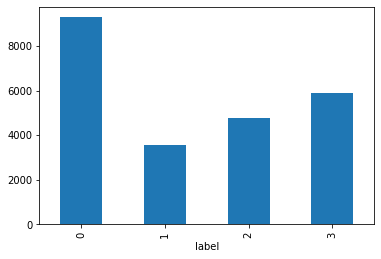

In [4]:
train.groupby('label')['org'].count().plot(kind='bar')

plt.show()

## Processing the date
- getting the weekday
- getting the hour

In [5]:
def ExtractDate(s):
    re_exp = '(0[\d]|[\d]|[12]\d|3[01])([ |-]+)([\D]{3})([ |-]+)([\d]{4}) ([\d]{2}):([\d]{2}):([\d]{2})([ ]+)?([\+|-][01][\d][0-5][\d]|\(?[\D]{3}\)?){0,1}'
    groups = re.match(re_exp, s.strip()).groups()
    
    date = None
    
    if groups[-1] is None: #No timezone information -> process date as UTC
        date = pd.to_datetime(' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7]), format='%d %b %Y %H %M %S')
        date = date.tz_localize(pytz.timezone("UTC"))
    
    elif groups[-1].startswith('+') or groups[-1].startswith('-') : #timezone as UTC offset, eg '+0500'
        date =  pd.to_datetime(' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7, 9]), format='%d %b %Y %H %M %S %z') 
    else: #timezone as text : 'UTC' or '(UTC)'
        date_wo_tzone = ' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7])
        if groups[9].startswith('('):
            tzone = groups[9][1:-1]
        else:
            tzone = groups[9]
            
        date =  pd.to_datetime(f'{date_wo_tzone} {tzone}', format='%d %b %Y %H %M %S %Z') 
    
    return date.astimezone(pytz.timezone("UTC"))

print(ExtractDate('01 Aug 2016 00:17:44 +0000'))
print(ExtractDate('01 Aug 2016 00:17:44 +0800'))
print(ExtractDate('01 Aug 2016 00:17:44 -0800'))
print(ExtractDate('13 Jun 2016 07:17:24 (UTC)'))
print(ExtractDate('13 Jun 2016 07:17:24 GMT'))
print(ExtractDate('11-MAR-2018 20:40:58'))
print(ExtractDate('13 Mar 2013 15:03:16 +0530 (IST)'))

2016-08-01 00:17:44+00:00
2016-07-31 16:17:44+00:00
2016-08-01 08:17:44+00:00
2016-06-13 07:17:24+00:00
2016-06-13 07:17:24+00:00
2018-03-11 20:40:58+00:00
2013-03-13 09:33:16+00:00


In [6]:
def TransformDateStringToDatetime(df):
    df['date']=df['date'].apply(lambda s : ExtractDate(s.split(',')[-1]))
    return df
    
train = TransformDateStringToDatetime(train)
test = TransformDateStringToDatetime(test)

In [7]:
print(train['date'].min(), train['date'].max())
print(test['date'].min(), test['date'].max())


2012-04-20 16:43:03+00:00 2019-10-30 16:29:47+00:00
2012-04-20 16:59:14+00:00 2019-10-31 08:20:54+00:00


In [8]:
def GetWeekDayAndHours(df):
    df['week_day'] = df['date'].apply(lambda s : s.day_name())
    
    #convert categorical data into indicator columns
    df = df.join(pd.get_dummies(df['week_day'], prefix='Cat'))
    
    #get the hour of the day
    #!!!!! maybe put the hours in buckets : 0-6 | 7-12 | 13 - 18 | 19 - 23
    df['Hour'] = df['date'].apply(lambda s : s.hour)
    df = df.join(pd.get_dummies(df['Hour'], prefix='Cat_Hour'))
    
    df.drop(columns=['week_day', 'Hour'], inplace=True)
    
    return df

train = GetWeekDayAndHours(train)
test = GetWeekDayAndHours(test)

## metrics from senders
For each sender, compute on the overall dataset the mean and variance of the email send for minutes, hours, months

In [9]:
#computing the email sender for train and test
train['sender'] = train['org'] + '.' + train['tld']
train['sender'] = train['sender'].str.lower()
test['sender'] = test['org'] + '.' + test['tld']
test['sender'] = test['sender'].str.lower()

In [10]:
def addSendersMetrics(df, df_merged):
    '''
    For each sender from df_merged, compute the number of emails sent on the overall dataset 
    and the mean and variance of the email send for minutes, hours, months
    
    df_merged: the dataset use for metric computation, normally train + test
    df : df that will be enriched with the metrics
    '''
    #compute the number of email send from sender:
    data = df_merged.groupby('sender')['Unnamed: 0'].count().rename('sender_count')
    df = df.join(data, on = ['sender'], how ='left')
    
    #add to df_merged datetime indicatord
    df_merged['Hour'] = df_merged['date'].apply(lambda s : s.hour)
    df_merged['Month'] = df_merged['date'].apply(lambda s : s.month)
    df_merged['Year'] = df_merged['date'].apply(lambda s : s.year)
    df_merged['Minute'] = df_merged['date'].apply(lambda s : s.minute)
    
    #compute mean and variance for each previous indicator
    for item in tqdm(['Hour', 'Month', 'Year', 'Minute', 'chars_in_body', 'chars_in_subject']):
        for indicator in ['mean', 'std']:
            data = df_merged.groupby('sender')[item].agg(indicator).rename(f'sender_{item}_{indicator}')
            df = df.join(data, on = ['sender'], how ='left')
    return df

df_merged = pd.concat([train, test], sort=False)
train = addSendersMetrics(train, df_merged)
test = addSendersMetrics(test, df_merged)

In [11]:
train.head(5)

,Unnamed: 0,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,Cat_Friday,Cat_Monday,Cat_Saturday,Cat_Sunday,Cat_Thursday,Cat_Tuesday,Cat_Wednesday,Cat_Hour_0,Cat_Hour_1,Cat_Hour_2,Cat_Hour_3,Cat_Hour_4,Cat_Hour_5,Cat_Hour_6,Cat_Hour_7,Cat_Hour_8,Cat_Hour_9,Cat_Hour_10,Cat_Hour_11,Cat_Hour_12,Cat_Hour_13,Cat_Hour_14,Cat_Hour_15,Cat_Hour_16,Cat_Hour_17,Cat_Hour_18,Cat_Hour_19,Cat_Hour_20,Cat_Hour_21,Cat_Hour_22,Cat_Hour_23,sender,sender_count,sender_Hour_mean,sender_Hour_std,sender_Month_mean,sender_Month_std,sender_Year_mean,sender_Year_std,sender_Minute_mean,sender_Minute_std,sender_chars_in_body_mean,sender_chars_in_body_std,sender_chars_in_subject_mean,sender_chars_in_subject_std
0,0,2016-08-28 00:17:44+00:00,amazon,in,0,0,multipart/mixed,0,0,0,0,102,4,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,amazon.in,1676.0,5.447494,6.118061,6.517303,3.226985,2017.489857,0.920359,24.942721,16.578650,39311.581742,4.141167e+04,50.644988,25.912548
1,1,2016-06-13 07:17:24+00:00,linkedin,com,0,0,multipart/alternative,15,44,0,0,55,35444,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,linkedin.com,1285.0,10.259922,6.251055,6.449027,3.343743,2016.175097,1.147801,21.110506,17.441141,51109.677043,3.794571e+04,53.509728,26.823572
2,2,2017-11-21 13:03:34+00:00,quora,com,0,0,multipart/alternative,12,110,1,1,59,100770,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,quora.com,1241.0,12.439162,5.792352,6.838840,3.071168,2016.434327,1.379837,28.338437,17.230783,72206.340854,3.594617e+04,86.020145,37.100218
3,3,2016-08-03 06:52:52+00:00,iiitd,ac.in,0,0,multipart/alternative,0,0,0,0,8,117,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,iiitd.ac.in,6313.0,9.692381,4.571198,6.807382,3.508630,2016.139712,0.777208,29.533661,17.268820,477651.959449,3.003616e+06,44.991763,26.440099
4,4,2019-02-14 09:37:30+00:00,mail,paypal.com,0,0,multipart/alternative,5,49,1,0,42,36472,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,mail.paypal.com,47.0,6.744681,4.687950,6.148936,2.941301,2017.340426,1.027377,25.000000,15.877247,83475.361702,4.066731e+04,59.595745,21.377212


## Processing mail type
Convert categorical data to indicator columns

'multipart/mixed', 'multipart/alternative', 'text/html',
'text/plain', nan, 'multipart/related', 'text/html ',
'multipart/idm'

In [12]:
def ConvertMailTypeToIndicators(df):
    df['mail_type'] = df['mail_type'].str.lower()
    df['mail_type'] = df['mail_type'].apply(lambda x : str(x).strip())
    df = df.join(pd.get_dummies(df['mail_type'], prefix='Cat_MailType'))
    df.drop(columns=['mail_type'], inplace=True)
    return df

train = ConvertMailTypeToIndicators(train)
test = ConvertMailTypeToIndicators(test)
#add missing mail type on test
test['Cat_MailType_multipart/idm'] = 0

In [13]:
def cleanOrgAndTld(df):
    for col in ['org', 'tld']:
        df[col]=df[col].str.lower()
        df[col]=df[col].apply(lambda s : str(s).strip())
    return df

print('Number of org and tld before cleaning')
print('org in train :', len(train['org'].unique()))
print('org in test :', len(test['org'].unique()))

print('tld in train :', len(train['tld'].unique()))
print('tld in test :', len(test['tld'].unique()))


#train = cleanOrgAndTld(train)
#test = cleanOrgAndTld(test)

print('Number of org and tld after cleaning')
print('org in train :', len(train['org'].unique()))
print('org in test :', len(test['org'].unique()))

print('tld in train :', len(train['tld'].unique()))
print('tld in test :', len(test['tld'].unique()))

Number of org and tld before cleaning
org in train : 656
org in test : 481
tld in train : 191
tld in test : 143
Number of org and tld after cleaning
org in train : 656
org in test : 481
tld in train : 191
tld in test : 143


## Processing organization
Data analysis shows that on train data, organization from Forum are exclusive from Social
=> We will add two indicators : Cat_is_known_forum_org, Cat_is_known_social_org

In [14]:
#look at intersection accross labels
update_set = set(train[train['label']==0]['org'].unique())
social_set = set(train[train['label']==1]['org'].unique())
forum_set = set(train[train['label']==2]['org'].unique())
promo_set = set(train[train['label']==3]['org'].unique())

print('update set len' , len(update_set))
print('inter forum ' , len(update_set.intersection(forum_set)),
     'inter social ' , len(update_set.intersection(social_set)),
     'inter promo ' , len(update_set.intersection(promo_set)))

print('social set' , len(social_set))
print('inter forum ' , len(social_set.intersection(forum_set)),
     'inter update ' , len(social_set.intersection(update_set)),
     'inter promo ' , len(social_set.intersection(promo_set)))

print('forum set' , len(forum_set))
print('inter social ' , len(forum_set.intersection(social_set)),
     'inter update ' , len(forum_set.intersection(update_set)),
     'inter promo ' , len(forum_set.intersection(promo_set)))

print('promo set' , len(promo_set))
print('inter social ' , len(promo_set.intersection(social_set)),
     'inter update ' , len(promo_set.intersection(update_set)),
     'inter forum ' , len(promo_set.intersection(forum_set)))

#look at intersection between train and test
train_org = set(train['org'].unique())
test_org = set(test['org'].unique())

print('nb org train :', len(train_org), 'nb org test :', len(test_org))
print('intersection :',len(train_org.intersection(test_org)))


print('forum set :', forum_set)
print('social set :', social_set)

update set len 551
inter forum  8 inter social  14 inter promo  158
social set 23
inter forum  0 inter update  14 inter promo  11
forum set 21
inter social  0 inter update  8 inter promo  4
promo set 242
inter social  11 inter update  158 inter forum  4
nb org train : 656 nb org test : 481
intersection : 413
forum set : {nan, '126', 'in', 'hotmail', 'centralesupelec', 'inria', 'sc', 'lss', 'gmail', 'student-cs', 'ZOONIVERSE', 'stackexchange', 'nptel', 'iiitd', 'github', 'supelec', 'maillist', 'ecp', 'geeps', 'googlegroups', 'student'}
social set : {'facebookmail', 'emails', 'twitter', 'youtube', 'researchgate', 'invite', 'rdio', 'academia', 'notifications', 'mailer', 'e', 'linkedin', 'explore', 'adultfriendfinder', 'foursquare', 'quora', 'academia-mail', 'mail', 'pinterest', 'researchgatemail', 'plus', 'flickr', 'internations'}


In [15]:
def AddPromoOrForumOrgInfo(df, forum_set, social_set):
    df['Cat_is_known_forum_org'] = df['org'].apply(lambda x : int(x in forum_set))
    df['Cat_is_known_social_org'] = df['org'].apply(lambda x : int(x in social_set))
    
    df.drop(columns=['org'], inplace=True)
    
    return df

train = AddPromoOrForumOrgInfo(train, forum_set, social_set)
test = AddPromoOrForumOrgInfo(test, forum_set, social_set)
    

## Processing TLD
Apply same strategy as organization

In [16]:
#look at intersection accross labels
update_set = set(train[train['label']==0]['tld'].unique())
social_set = set(train[train['label']==1]['tld'].unique())
forum_set = set(train[train['label']==2]['tld'].unique())
promo_set = set(train[train['label']==3]['tld'].unique())

print('update set len' , len(update_set))
print('inter forum ' , len(update_set.intersection(forum_set)),
     'inter social ' , len(update_set.intersection(social_set)),
     'inter promo ' , len(update_set.intersection(promo_set)))

print('social set' , len(social_set))
print('inter forum ' , len(social_set.intersection(forum_set)),
     'inter update ' , len(social_set.intersection(update_set)),
     'inter promo ' , len(social_set.intersection(promo_set)))

print('forum set' , len(forum_set))
print('inter social ' , len(forum_set.intersection(social_set)),
     'inter update ' , len(forum_set.intersection(update_set)),
     'inter promo ' , len(forum_set.intersection(promo_set)))

print('promo set' , len(promo_set))
print('inter social ' , len(promo_set.intersection(social_set)),
     'inter update ' , len(promo_set.intersection(update_set)),
     'inter forum ' , len(promo_set.intersection(forum_set)))

#look at intersection between train and test
train_org = set(train['tld'].unique())
test_org = set(test['tld'].unique())

print('nb tld train :', len(train_org), 'nb tld test :', len(test_org))
print('intersection :',len(train_org.intersection(test_org)))

print('forum set :', forum_set)
print('social set :', social_set)

update set len 149
inter forum  7 inter social  8 inter promo  60
social set 12
inter forum  1 inter update  8 inter promo  7
forum set 12
inter social  1 inter update  7 inter promo  6
promo set 93
inter social  7 inter update  60 inter forum  6
nb tld train : 191 nb tld test : 143
intersection : 125
forum set : {nan, 'codeproject.com', 'ecp.fr', 'centralesupelec.fr', 'com', 'ibm.com', 'ORG', 'iitm.ac.in', 'ac.in', 'fr', 'iiitd.ac.in', 'supelec.fr'}
social set : {'net', 'edu', 'org', 'last.fm', 'com', 'goodreads.com', 'skype.com', 'instagram.com', 'linkedin.com', 'quoramail.com', 'google.com', 'pinterest.com'}


In [17]:
def AddPromoOrForumTldInfo(df, forum_set, social_set):
    df['Cat_is_known_forum_tld'] = df['tld'].apply(lambda x : int(x in forum_set))
    df['Cat_is_known_social_tld'] = df['tld'].apply(lambda x : int(x in social_set))
    
    df.drop(columns=['tld'], inplace=True)
    
    return df

train = AddPromoOrForumTldInfo(train, forum_set, social_set)
test = AddPromoOrForumTldInfo(test, forum_set, social_set)
    

## Processing sender

In [18]:
len((train['sender']).unique())

746

In [19]:
#look at intersection accross labels
update_set = set(train[train['label']==0]['sender'].unique())
social_set = set(train[train['label']==1]['sender'].unique())
forum_set = set(train[train['label']==2]['sender'].unique())
promo_set = set(train[train['label']==3]['sender'].unique())

print('update set len' , len(update_set))
print('inter forum ' , len(update_set.intersection(forum_set)),
     'inter social ' , len(update_set.intersection(social_set)),
     'inter promo ' , len(update_set.intersection(promo_set)))

print('social set' , len(social_set))
print('inter forum ' , len(social_set.intersection(forum_set)),
     'inter update ' , len(social_set.intersection(update_set)),
     'inter promo ' , len(social_set.intersection(promo_set)))

print('forum set' , len(forum_set))
print('inter social ' , len(forum_set.intersection(social_set)),
     'inter update ' , len(forum_set.intersection(update_set)),
     'inter promo ' , len(forum_set.intersection(promo_set)))

print('promo set' , len(promo_set))
print('inter social ' , len(promo_set.intersection(social_set)),
     'inter update ' , len(promo_set.intersection(update_set)),
     'inter forum ' , len(promo_set.intersection(forum_set)))

#look at intersection between train and test
train_org = set(train['sender'].unique())
test_org = set(test['sender'].unique())

print('nb sender train :', len(train_org), 'nb sender test :', len(test_org))
print('intersection :',len(train_org.intersection(test_org)))

print('forum set :', forum_set)
print('social set :', social_set)

update set len 613
inter forum  6 inter social  12 inter promo  164
social set 25
inter forum  0 inter update  12 inter promo  7
forum set 21
inter social  0 inter update  6 inter promo  3
promo set 273
inter social  7 inter update  164 inter forum  3
nb sender train : 746 nb sender test : 532
intersection : 455
forum set : {nan, 'in.ibm.com', 'sc.iiitd.ac.in', 'zooniverse.org', 'github.com', 'centralesupelec.fr', 'maillist.codeproject.com', '126.com', 'lss.supelec.fr', 'gmail.com', 'nptel.iitm.ac.in', 'supelec.fr', 'ecp.fr', 'inria.fr', 'stackexchange.com', 'student.ecp.fr', 'geeps.centralesupelec.fr', 'hotmail.fr', 'student-cs.fr', 'googlegroups.com', 'iiitd.ac.in'}
social set : {'twitter.com', 'explore.pinterest.com', 'mailer.last.fm', 'rdio.com', 'invite.quoramail.com', 'facebookmail.com', 'notifications.skype.com', 'mail.goodreads.com', 'adultfriendfinder.com', 'researchgate.net', 'notifications.pinterest.com', 'e.linkedin.com', 'academia-mail.com', 'internations.org', 'plus.googl

In [20]:
def AddSenderLabelInfo(df, forum_set, social_set, promo_set, update_set):
    df['Cat_is_known_forum_sender'] = df['sender'].apply(lambda x : int(x in forum_set))
    df['Cat_is_known_social_sender'] = df['sender'].apply(lambda x : int(x in social_set))
    df['Cat_is_known_promo_sender'] = df['sender'].apply(lambda x : int(x in promo_set))
    df['Cat_is_known_update_sender'] = df['sender'].apply(lambda x : int(x in update_set))
    
    return df

train = AddSenderLabelInfo(train, forum_set, social_set, promo_set, update_set)
test = AddSenderLabelInfo(test, forum_set, social_set, promo_set, update_set)

## Save data to file

In [21]:
#Ensure that train and test have the same columns order
train = train.reindex(columns = sorted(train.columns)).fillna(0)
test = test.reindex(columns = sorted(test.columns)).fillna(0)

train.drop(columns=['Unnamed: 0', 'date', 'sender'], inplace=True)
test.drop(columns=['Unnamed: 0', 'date', 'sender'], inplace=True)

train.columns

Index(['Cat_Friday', 'Cat_Hour_0', 'Cat_Hour_1', 'Cat_Hour_10', 'Cat_Hour_11',
       'Cat_Hour_12', 'Cat_Hour_13', 'Cat_Hour_14', 'Cat_Hour_15',
       'Cat_Hour_16', 'Cat_Hour_17', 'Cat_Hour_18', 'Cat_Hour_19',
       'Cat_Hour_2', 'Cat_Hour_20', 'Cat_Hour_21', 'Cat_Hour_22',
       'Cat_Hour_23', 'Cat_Hour_3', 'Cat_Hour_4', 'Cat_Hour_5', 'Cat_Hour_6',
       'Cat_Hour_7', 'Cat_Hour_8', 'Cat_Hour_9',
       'Cat_MailType_multipart/alternative', 'Cat_MailType_multipart/idm',
       'Cat_MailType_multipart/mixed', 'Cat_MailType_multipart/related',
       'Cat_MailType_nan', 'Cat_MailType_text/html', 'Cat_MailType_text/plain',
       'Cat_Monday', 'Cat_Saturday', 'Cat_Sunday', 'Cat_Thursday',
       'Cat_Tuesday', 'Cat_Wednesday', 'Cat_is_known_forum_org',
       'Cat_is_known_forum_sender', 'Cat_is_known_forum_tld',
       'Cat_is_known_promo_sender', 'Cat_is_known_social_org',
       'Cat_is_known_social_sender', 'Cat_is_known_social_tld',
       'Cat_is_known_update_sender', 'bcced',

In [22]:
print(train.shape)
print(test.shape)

display(train.head(5))
display(test.head(5))

(24840, 68)
(10647, 67)


,Cat_Friday,Cat_Hour_0,Cat_Hour_1,Cat_Hour_10,Cat_Hour_11,Cat_Hour_12,Cat_Hour_13,Cat_Hour_14,Cat_Hour_15,Cat_Hour_16,Cat_Hour_17,Cat_Hour_18,Cat_Hour_19,Cat_Hour_2,Cat_Hour_20,Cat_Hour_21,Cat_Hour_22,Cat_Hour_23,Cat_Hour_3,Cat_Hour_4,Cat_Hour_5,Cat_Hour_6,Cat_Hour_7,Cat_Hour_8,Cat_Hour_9,Cat_MailType_multipart/alternative,Cat_MailType_multipart/idm,Cat_MailType_multipart/mixed,Cat_MailType_multipart/related,Cat_MailType_nan,Cat_MailType_text/html,Cat_MailType_text/plain,Cat_Monday,Cat_Saturday,Cat_Sunday,Cat_Thursday,Cat_Tuesday,Cat_Wednesday,Cat_is_known_forum_org,Cat_is_known_forum_sender,Cat_is_known_forum_tld,Cat_is_known_promo_sender,Cat_is_known_social_org,Cat_is_known_social_sender,Cat_is_known_social_tld,Cat_is_known_update_sender,bcced,ccs,chars_in_body,chars_in_subject,designation,images,label,salutations,sender_Hour_mean,sender_Hour_std,sender_Minute_mean,sender_Minute_std,sender_Month_mean,sender_Month_std,sender_Year_mean,sender_Year_std,sender_chars_in_body_mean,sender_chars_in_body_std,sender_chars_in_subject_mean,sender_chars_in_subject_std,sender_count,urls
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,4,102,0,0,3,0,5.447494,6.118061,24.942721,16.578650,6.517303,3.226985,2017.489857,0.920359,39311.581742,4.141167e+04,50.644988,25.912548,1676.0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,35444,55,0,15,1,0,10.259922,6.251055,21.110506,17.441141,6.449027,3.343743,2016.175097,1.147801,51109.677043,3.794571e+04,53.509728,26.823572,1285.0,44
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,0,0,100770,59,1,12,1,1,12.439162,5.792352,28.338437,17.230783,6.838840,3.071168,2016.434327,1.379837,72206.340854,3.594617e+04,86.020145,37.100218,1241.0,110
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,117,8,0,0,2,0,9.692381,4.571198,29.533661,17.268820,6.807382,3.508630,2016.139712,0.777208,477651.959449,3.003616e+06,44.991763,26.440099,6313.0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,36472,42,0,5,3,1,6.744681,4.687950,25.000000,15.877247,6.148936,2.941301,2017.340426,1.027377,83475.361702,4.066731e+04,59.595745,21.377212,47.0,49


,Cat_Friday,Cat_Hour_0,Cat_Hour_1,Cat_Hour_10,Cat_Hour_11,Cat_Hour_12,Cat_Hour_13,Cat_Hour_14,Cat_Hour_15,Cat_Hour_16,Cat_Hour_17,Cat_Hour_18,Cat_Hour_19,Cat_Hour_2,Cat_Hour_20,Cat_Hour_21,Cat_Hour_22,Cat_Hour_23,Cat_Hour_3,Cat_Hour_4,Cat_Hour_5,Cat_Hour_6,Cat_Hour_7,Cat_Hour_8,Cat_Hour_9,Cat_MailType_multipart/alternative,Cat_MailType_multipart/idm,Cat_MailType_multipart/mixed,Cat_MailType_multipart/related,Cat_MailType_nan,Cat_MailType_text/html,Cat_MailType_text/plain,Cat_Monday,Cat_Saturday,Cat_Sunday,Cat_Thursday,Cat_Tuesday,Cat_Wednesday,Cat_is_known_forum_org,Cat_is_known_forum_sender,Cat_is_known_forum_tld,Cat_is_known_promo_sender,Cat_is_known_social_org,Cat_is_known_social_sender,Cat_is_known_social_tld,Cat_is_known_update_sender,bcced,ccs,chars_in_body,chars_in_subject,designation,images,salutations,sender_Hour_mean,sender_Hour_std,sender_Minute_mean,sender_Minute_std,sender_Month_mean,sender_Month_std,sender_Year_mean,sender_Year_std,sender_chars_in_body_mean,sender_chars_in_body_std,sender_chars_in_subject_mean,sender_chars_in_subject_std,sender_count,urls
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,955708,39,0,0,0,9.692381,4.571198,29.533661,17.268820,6.807382,3.508630,2016.139712,0.777208,477651.959449,3.003616e+06,44.991763,26.440099,6313.0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,137106,53,0,31,1,6.744681,4.687950,25.000000,15.877247,6.148936,2.941301,2017.340426,1.027377,83475.361702,4.066731e+04,59.595745,21.377212,47.0,165
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,45560,55,0,3,0,17.428571,2.541091,5.857143,8.205399,6.523810,0.511766,2019.000000,0.000000,49263.523810,1.204427e+04,26.619048,11.625301,21.0,41
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,2866,39,0,1,1,13.020877,1.529207,33.498956,18.703240,6.789144,3.263114,2013.659708,0.516531,24687.935282,3.211052e+03,52.342380,10.146608,479.0,7
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,10449,55,0,16,0,12.000000,0.000000,4.000000,1.414214,8.500000,0.707107,2018.000000,0.000000,10449.000000,0.000000e+00,55.000000,0.000000,2.0,27


In [23]:
train.to_csv('../data/generated/Knn_train_eng.csv', index=False)
test.to_csv('../data/generated/Knn_test_eng.csv', index=False)